# Метод прогонки и LU разложение.

Попробуем численно решить уравнение Пуассона 
$$\Delta u(x,y)=f(x,y),\quad \Delta=\partial_x^2+\partial_y^2,$$
на квадрате $(x,y)\in[-1,1]^{\times 2}$ с периодическими граничными условиями 
$$\begin{cases}
u(-1,y)=u(1,y),\;\partial_x u(-1,y)=\partial_x u(1,y),\\
u(x,-1)=u(x,1),\;\partial_y u(x,-1)=\partial_y u(x,1).
\end{cases}
$$
Для тестирования удобно использовать явнорешаемую задачу,
для примера рассмотрим правую часть специального вида 
$$f(x,y)=\cos \pi x\cos \pi y,$$
для которой аналитическое решение легко выписывается:
$$u(x,y)=-2\pi^{-2}\cos\pi x\cos \pi y.$$

Выполним дискретизацию на сетке:
$$x_k=\frac{k-N}{N},\quad y_n=\frac{n-N}{N},\quad u_{kn}=u(x_k,y_n),\quad f_{kn}=f(x_k,y_n),\quad k,n=0\ldots 2N-1.$$
Произоводные заменим на центральные конечные отношения:
$$\Delta u_{kn}=\frac{u_{k+1,n}+u_{k-1,n}+u_{k,n+1}+u_{k,n-1}-4u_{kn}}{\delta^2},$$
где шаг решетки обозначен $\delta=1/N$.
В сеточной дискретизации систему можно записать в матричном виде:
$$Au=f,\quad \sum_{k',n'} A_{k,n;k',n'}u_{k',n'}=f_{k,n}.$$
Здесь пара чисел $(k,n)$ отвечает одной координате вектора.
Элементы матрицы $A$ легко выписываются:
$$A_{k,n;k',n'}=\begin{cases}
N^2,& |n-n'|+|k-k'|=1,\\
-4N^2, & n=n', k=k',\\
0,& \text{в остальных случаях}.
\end{cases}.$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

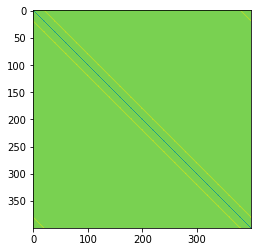

Число обусловленности 6.737506186406623e+16


In [2]:
def matrix_A(N):
    A = np.zeros( (2*N,)*4 ) # Матрица разрежена, значит начинаем с нулевой матрицы.
    k = np.arange(2*N)[:,None] # Все возможные значения индекса для x координаты.
    kplus = ((k+1)%(2*N)) # Ячейка правее, чем указанная в массиве k.
    n = np.arange(2*N)[None,:] # Все возможные значения индекса для y координаты.
    nplus = ((n+1)%(2*N)) # Ячейка выше, чем указанная в массиве n.
    A[k,n,k,n] = -4*N**2 # Устанавливаем все диагональные элементы.
    A[k,nplus,k,n] = N**2 # Устанавливаем значения для соседей по вертикали.
    A[k,n,k,nplus] = N**2 
    A[kplus,n,k,n] = N**2 # и по горизонтали.
    A[k,n,kplus,n] = N**2 
    return A

def flatten_matrix(A):
    """Преобразует матрицу со сложными индексами в обучную матрицу в числовыми индексами."""
    N, M, N1, M1 = A.shape
    return A.reshape((N*M, N1*M1))

# Посмотрим на структуру матрицы.
A=matrix_A(10)
plt.imshow(flatten_matrix(A)) # Для отрисовки приведем ее к обычному виду - квадратному массиву.
plt.show()
# Матрица разреженная, причем ее можно представить трехдиагональном виде, однако на диагонали стоят блоки.

print("Число обусловленности", np.linalg.cond(flatten_matrix(A)))
# Число обусловленности получается около 6e16, а значит решение систем с такой матрицей не дает 
# ни одного верного знака в ответе.

Ошибка решения: 0.06594157250039044
Невязка на численном решении: 8.504308368628699e-14
Невязка на аналитическом решении: 2.5979218776228663e-14


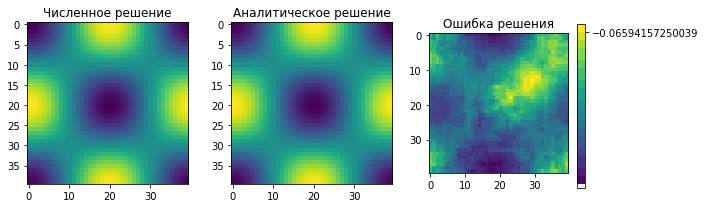

In [3]:
def grid_x(N): 
    """Считает сетку для координаты x."""
    return np.arange(2*N)/N-1

def grid_y(N): 
    """Считает сетку для координаты y."""
    return np.arange(2*N)/N-1
    
def problem_1(N):
    """
    Возвращает пару (f, u), где 
        `f` - правая часть уравнения Пуассона в узлах решетки,
        `u` - аналитическое решение ДИСКРЕТИЗОВАННОГО уравнения Пуассона с правой частью `f`.
    """
    x, y = grid_x(N)[:,None], grid_y(N)[None,:]
    f = np.cos(np.pi*x)*np.cos(np.pi*y)
    mu = 4*(np.cos(np.pi/N)-1)*N**2 # Собственное значение дискретизации оператора Лапласа отвечающее f.
    u = f/mu
    return f, u
    
def solve_poisson_using_np(f):
    """
    Решает уравнение Пуассона с заданной правой частью `f`.
    Возвращает решение `u` и невязку `r`.
    """
    N = f.shape[0]//2
    A = matrix_A(N)
    Af = flatten_matrix(A) # Превращаем мультииндекс в целое число.
    ff = f.flatten()
    u = np.linalg.solve( Af, ff )
    r = ff-Af@u
    return u.reshape(f.shape), r.reshape(f.shape)


N = 20
f, u0 = problem_1(N)
u, r = solve_poisson_using_np(f)
# print("Приближенное решение:", u[:5,:5] )
# print("Точное решение:", u0[:5,:5] )
# print("Ошибка:", u[:5,:5] - u0[:5,:5] )
print("Ошибка решения:", np.linalg.norm( (u-u0).flatten(), ord=np.inf ))
print("Невязка на численном решении:", np.linalg.norm( (r).flatten(), ord=np.inf ))

Af = flatten_matrix(matrix_A(N))
r0 = f.flatten()-Af@u0.flatten()
print("Невязка на аналитическом решении:", np.linalg.norm( (r0).flatten(), ord=np.inf ))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3))
ax1.imshow(u.T)
ax2.imshow(u0.T)
im=ax3.imshow((u-u0).T)
plt.colorbar(im, ax=ax3)
ax1.set_title("Численное решение")
ax2.set_title("Аналитическое решение")
ax3.set_title("Ошибка решения")
plt.tight_layout()
plt.show()

# Визуальное решение получилось очень похожим на верное, однако ошибка решения очень велика, хотя невязка мала. 

In [4]:
# Можно заметить, что численное решение отличается на константу от аналитического.
print("Среднее значение численного решения:", np.mean(u))
print("Среднее значение аналитического решения", np.mean(u0))
# Так как решение уравнения Пуассона с периодическими граничными условиями определено не однозначно,
# и мы никак не ограничивали свободу решения, то не удивительно, что мы получили не ожидаемое решение.
# Попробуем вычесть среднее и снова посчитаем ошибку.
u_corrected = u-np.mean(u)
print("Ошибка решения с поправкой на константу:", np.linalg.norm( (u_corrected-u0).flatten(), ord=np.inf ))
# Ошибка стала меньше, но не исчезла совсем.

Среднее значение численного решения: -0.06594157250039023
Среднее значение аналитического решения -1.734723475976807e-20
Ошибка решения с поправкой на константу: 2.5196858488563123e-16


## Задание

1. Объясните, почему решение находится практически точно с точностью до постоянного слагаемого, хотя матрица системы плохообусловленна? Как можно теоретически оценить точность решения, если после решения системы мы будем вычитать из решения его среднее? При любой ли правой части $f$ системы сработает трюк с вычитанием среднего?

Чтобы однозначно зафиксировать решение, положим, что среднее значение решения должно быть равно нулю.
$$\int_{-1}^1\int_{-1}^1u(x,y)dxdy=0.$$
Другими словами, мы потребовали, чтобы проекция решения на пространство постоянных функций была равна нулю.
Так как это пространство является инвариантным (собственным) для оператора Лапласа, 
то для автоматического выполнения условия обращения среднего значения в ноль, достаточно переопределить оператор $A$ в системе $Au=f$ на подпространстве постоянных функций так, чтобы он действовал в этом пространстве умножением на отличную от нуля константу:
$$A\mapsto A-|1\rangle\langle1|,$$
где $|1\rangle\langle1|$ обозначает матрицу, все элементы которой равны единице,
а вектор $f$ в правой части нужно изменить так, чтобы его среднее было равно нулю:
$$f\mapsto f-\textrm{mean}(f).$$

In [5]:
def solve_poisson_fix1(f):
    """
    Решает уравнение Пуассона, делая поправку на постоянных функциях.
    """
    N = f.shape[0]//2
    A = matrix_A(N)
    # Превращаем мультииндекс в целое число.
    Af = flatten_matrix(A) 
    ff = f.flatten()
    # Исправляем поведение на постоянных функциях.
    Af -= 1/N
    ff -= np.mean(ff)
    # Матрица обусловлена теперь гораздо лучше.
#     print(f"Число обусловленности исправленной системы", np.linalg.cond(Af))
    # Решаем систему.
    u = np.linalg.solve( Af, ff )
    r = ff-Af@u
    return u.reshape(f.shape), r.reshape(f.shape)

f, u0 = problem_1(20)
u, r = solve_poisson_fix1(f)
print(f"Среднее значение численного решения:", np.mean(u))
print("Невязка:", np.linalg.norm( (r).flatten(), ord=np.inf ))
print("Ошибка решения:", np.linalg.norm( (u-u0).flatten(), ord=np.inf ))

Среднее значение численного решения: -1.0408340855860842e-19
Невязка: 9.015010959956271e-14
Ошибка решения: 1.1449174941446927e-15


Переопределение действия оператора на подпространстве постоянных функций позволяет добиться единственности решения уравнения, а также позволяет добиться хорошей обусловленности задачи.
К сожалению, получающаяся матрица система не будет более разреженной (хотя и останется симметрической), что не позволит нам использовать решатели для ленточных матриц.
Наша поправка к матрице могла быть записана как добавление матрицы ранга $1$ к оператору Лапласа, 
однако это возмущение было не согласовано с базисом, в котором задана матрица оператора, что и привело к появлению большого числа ненулевых элементов.
Мы, однако, можем сделать другую поправку к матрице, так что решение системы по прежнему будет давать решение уравнения Пуассона, это решение будет единственным, и число ненулевых коэффициентов матрицы почти не изменится.
Действительно, матрица оператора $\Delta$ вырождена, следовательно, если правая часть системы такова, что решение системы существует, то одно из уравнений можно выбросить, что никак не повлияет на решение.
Но вместо выброшенного уравнения мы можем добавить новое, которое будет однозначно фиксировать аддитивную константу в решении.
Например, можно выбросить первое уравнение и вместо него потребовать, чтобы сумма всех коэффициентов решения $u$ была равна нулю, аналогично нормировки из прошлого подхода.
На практике, вместо требования на обращение в нуль среднего значения функции, удобнее потребовать обращения функции в нуль в каком-то одном узле решетки, например, $u(-1,-1)=0$. 
При такой нормировке в переопределенной строке матрицы будут стоять нули всюду, кроме диагонального элемента, и соответствующий элемент вектора $f$ также нужно обнулить.

## Задание.

2. Зафиксировав значение решения $u$ в одной точке мы получили корректную хорошо обусловленную задачу с разреженной матрицей, однако замена одной строки привела нас к не симметрической матрице. Какую преобразование мы должны сделать дальше, чтобы получить эквивалентную систему с разреженной симметрической матрицей?

В данном случае решать систему с помощью функции `numpy.linalg.solve` очень расточительно, так как мы не использовали информацию о структуре матрицы.
Большая часть операций при решении системы заключалась в умножении на ноль. Вашим заданием будет реализовать максимально эффективных решатель системы с фиксированной матрицей $A$ для произвольной правой части $f$. 

In [6]:
%%html
<!-- Скобки вокруг матрицы согласно https://stackoverflow.com/questions/11561137/html-css-for-brackets-around-mathematical-matrix-prefer-lightweight/11561235 --> 
<style>
    .matrix { position: relative; left: 6px; } 
    .matrix:before, .matrix:after { content: ""; position: absolute; top: 0; border: 1px solid #000; width: 6px; height: 100%; } 
    .matrix:before { left: -6px; border-right: 0; } 
    .matrix:after { right: -6px; border-left: 0; }
</style>

In [7]:
# Для того, чтобы ваше решение затем можно было переиспользовать и далее расширять, будет предпочтительным
# реализовать классы для матриц специального вида, реализующих общий интерфейс, позволяющий решать системы
# с этими матрицами и производить другие необходимые операции наиболее эффективным для каждого типа матриц способом.

from IPython.display import HTML, display

# Определим базовых класс, который будет выполнять операции с матрицами,
# приводя их к заполеннными и обрабатывая их функциями из numpy.
class Matrix:
    @property
    def shape(self): # Должно возвращать размер матрицы, но в базовом классе размер не известен.
        raise NotImplementedError() 
    def __add__(self, other): # Операция сложения матриц
        if isinstance(other, Matrix): # Определим сложение матрицы с матрицей.
            # Корректность операции нужно проверять, но numpy это уже делает.
#             assert self.shape == other.shape, "Несовпадение размеров" 
            return DenseMatrix(self.to_dense()+other.to_dense())
        else: return NotImplemented
    # Аналогично можно определить вычитание __sub__, поэлементное умножение __mul__ и т.п.
    # См. полный список операторов https://docs.python.org/3/library/operator.html
    def __matmul__(self, other): # Матричное умножение self@other.
        return DenseMatrix(self.to_dense()@other.to_dense())
    def solve(self, b):
        """Решает систему self@u=b."""
        assert self.shape[0]==b.shape[0]
        return np.linalg.solve(self.to_dense(), b.to_dense())
    def _repr_html_(self): # Jupyter может выводить объекты в разных видах, например, выведем матрицу в виде таблицы.
        return f'<table class="matrix">'+"".join([ '<tr>'+"".join([f"<td>{c}</td>" for c in row])+'</tr>' for row in self.to_dense() ])+'</table>'

# Реализация матриц, хранящая заполненную матрицу.
class DenseMatrix(Matrix):
    def __init__(self, data):
        """Создает плотную матрицу с коэффициентами из массива `data`."""
        self._data = np.array(data) # Сохраняем коэффициенты в приватной переменной преобразую в numpy.ndarray.
        assert self._data.ndim==2 # Проверим корректность данных.
    def __getitem__(self, key): # Извлечение элемента матрицы (или подматрицы).
        return self._data[key]
    def to_dense(self): # Преобразует матрицу к плотной матрице в виде массива numpy.
        return self._data # Возращается НЕ копия, возвращаемый массив не должен изменяться.
    @property
    def shape(self): # Возвращает размер матрицы
        return self._data.shape

    
a = DenseMatrix([[1,0],[0,2]])
b = DenseMatrix([[1,1],[0,1]])
display(a+a@b)

2,1
0,4


In [8]:
# Ленточные матрицы (имеющие небольшое число ненулевых диагоналей) дают пример матриц,
# которые можно хранить значительно компактнее матриц общего назначения, 
# расчеты с ними быстрее, чем с заполненными матрицами.
class BandMatrix(Matrix):
    def __init__(self, diagonal, lower_diagonals=[], upper_diagonals=[]):
        """
        Создает ленточную матрицу.
        `diagonal` - список элементов главной диагонали,
        `lower_diagonals` - список диагоналей ниже главной, начиная с ближайшей к главной.
        `upper_diagonals` - список диагоналей выше главной, начиная с ближайшей к главной.
        """
        self._diagonal = diagonal
        self._lower_diagonals = lower_diagonals
        self._upper_diagonals = upper_diagonals
    @property
    def n(self): return len(self._diagonal) # Размер матрицы (матрица всегда квадратная).
    @property
    def p(self): return len(self._lower_diagonals) # Число диагоналей ниже главной.
    @property
    def q(self): return len(self._upper_diagonals) # Число диагоналей выше главной.
    @property
    def shape(self): # Переопределяем вычисление размера 
        return (self.n,)*2
    def __getitem__(self, key): # Извлечение элемента матрицы (или подматрицы).
        (i,j) = key # Распаковываем индексы матрицы.
        d = j-i # Номер диагонали, верхние с плюсом.
        if d>self.q or d<-self.p: return 0 # Элемент вне ленты.
        n = (j+i-abs(d))//2 # Номер элемента на диагонали (считая от верхнего/левого элемента).
        return (self._diagonal[n] if d==0 else 
                self._upper_diagonals[d-1][n] if d>0 else 
                self._lower_diagonals[-d-1][n])
    def to_dense(self): # Преобразует матрицу к плотной матрице в виде массива numpy.
        result = np.zeros(self.shape)
        for i in range(self.shape[0]):
            for j in range(self.shape[1]): # TODO Можно перебирать меньше элементов.
                result[i,j] = self[i,j]
        return result
    # TODO Вычисления с матрицей происходять через преобразование к полной, что не оптимально.
    
    
a = BandMatrix(diagonal=[1,2,3,4], lower_diagonals=[[5,6,7],[8,9]], upper_diagonals=[[10,11,12]])
b = BandMatrix(diagonal=[1,1,1,1])
display(a@b)


1.0,10.0,0.0,0.0
5.0,2.0,11.0,0.0
8.0,6.0,3.0,12.0
0.0,9.0,7.0,4.0


# Задания.

3. Реализуйте методы для сложения, умножения и др. операций для ленточных матриц BandMatrix,
который будет принимать во внимание нулевые элементы.

4. Реализуйте [метод прогонки](https://ru.wikipedia.org/wiki/Метод_прогонки) для ленточных матриц. 

5. Чем метод прогонки отличается от [LU разложения](https://ru.wikipedia.org/wiki/LU-разложение)? Как будут выглядеть матрицы $L$ и $U$ для алгоритма прогонки?

6. Реализуйте класс BlockMatrix, оперирующий с блочными матрицами. 

7. Определите, к каким матрицам специального вида относится матрица $A$ из уравнения Пуассона.

8. Реализуйте максимально быстрый решатель уравнения Пуассона, 
использующий специальный вид матрицы.

9. Вычислите определитель оператора $A$, пользуясь блочным LU разложением. 

10. (Для расширения кругозора.) Как определитель матрицы $A$ связан с [определителем оператора $\Delta$](https://en.wikipedia.org/wiki/Functional_determinant)?